In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# Constants
h = 6.602e-34
hbar = h/(2*np.pi)
kB = 1.38e-23
eps_0 = 8.85e-12
c_0 = 299792458
e = 1.602e-19
m_e = 9.109e-31
a_0 = 0.53e-10
norm = 1e-9
mu_B = e*hbar/(2*m_e)

In [3]:
#Internal basis vectors expressed in lab frame. SiV high symmetry axis is along z: <111>
x = np.array([-1,1,0])
x = x/np.linalg.norm(x)
y = np.array([-1,-1,2])
y = y/np.linalg.norm(y)
z = np.array([1,1,1])
z = z/np.linalg.norm(z)

#Rotation matrix to switch from internal to external lab frame
R_ext_int = np.vstack((x,y,z)).T
R_int_ext = np.linalg.inv(R_ext_int)

In [4]:
''' 
    States and operators:
    Orbitals ordering
    0: |e_gx>
    1: |e_gy>
    2: |e_ux>
    3: |e_uy>

    Therefore orbital plus operator L_p_x = |e_g_y><e_g_x| ... 
    Due to D3d symmetry only L_z is non-zero. L_x and L_y vanish.

    Define spin up |🠕> as lower energy state.
'''
N_orbs = 4 
e_g_x = basis(N_orbs, 0)
e_g_y = basis(N_orbs, 1)
e_u_x = basis(N_orbs, 2)
e_u_y = basis(N_orbs, 3)
L_p_g = e_g_y*e_g_x.dag()
L_m_g = L_p_g.trans()
L_p_e = e_u_y*e_u_x.dag()
L_m_e = L_p_e.trans()
L_z_g = (1j*L_m_g-1j*L_p_g)
L_z_e = (1j*L_m_e-1j*L_p_e)

N_spins = 2
s_down = basis(N_spins,0)
s_up = basis(N_spins,1)
S_m = s_down*s_up.dag()
S_p = s_up*s_down.dag()
S_x = 1/2*(S_m + S_p)
S_y = 1/2*(-1j*S_m + 1j*S_p)
S_z = 1/2*(s_down*s_down.dag() - s_up*s_up.dag())
N = N_orbs*N_spins

In [5]:
'''System Dynamics:
Orbital part comprising Spin-Orbit, Jahn Teller, Zeeman and Strain couplin
'''
HOrb = Qobj(np.zeros((N_orbs, N_orbs)))
HOrb += 1.68*e/h*(e_u_x*e_u_x.dag()+e_u_y*e_u_y.dag())
H = tensor(HOrb, qeye(N_spins))

In [6]:
#Spin-Orbit coupling
SO_g = 46e9
SO_e = 250e9
HSO = -SO_g/2*tensor(L_z_g,S_z) - SO_e/2*tensor(L_z_e,S_z)
H += HSO

In [8]:
#Jahn-Teller coupling
JT_x_g = 0
JT_x_e = 0
JT_y_g = 0
JT_y_e = 0
HJT = JT_x_g*e_g_x*e_g_x.dag()
HJT += JT_y_g*e_g_x*e_g_y.dag()
HJT += JT_y_g*e_g_y*e_g_x.dag()
HJT += -JT_x_g*e_g_y*e_g_y.dag()
HJT += JT_x_e*e_u_x*e_u_x.dag()
HJT += JT_y_e*e_u_x*e_u_y.dag()
HJT += JT_y_e*e_u_y*e_u_x.dag()
HJT += -JT_x_e*e_u_y*e_u_y.dag()
H += tensor(HJT, qeye(N_spins))

In [11]:
#Strain coupling
delta_g = 0
alpha_g = 0
beta_g = 0
HStr_g = (delta_g+alpha_g)*e_g_x*e_g_x.dag()
HStr_g += beta_g*e_g_x*e_g_y.dag()
HStr_g += beta_g*e_g_y*e_g_x.dag()
HStr_g += (delta_g-alpha_g)*e_g_y*e_g_y.dag()

delta_e = 0
alpha_e = 0
beta_e = 0
HStr_e = (delta_e+alpha_e)*e_u_x*e_u_x.dag()
HStr_e += beta_e*e_u_x*e_u_y.dag()
HStr_e += beta_e*e_u_y*e_u_x.dag()
HStr_e += (delta_e-alpha_e)*e_u_y*e_u_y.dag()

HStr = HStr_g + HStr_e

H += tensor(HStr, qeye(N_spins))

In [12]:
#Magnetic field unit vector
e_B_ext = np.array([[0],[0],[1]])
e_B_ext = e_B_ext/np.linalg.norm(e_B_ext)
Bs = np.linspace(0,7,100)

energies = np.zeros((N, len(Bs)))
for i, B in enumerate(Bs):

    #Zeeman coupling with quenching factor of f=0.1
    f = 0.1
    gamma_S = 2*mu_B/h
    gamma_L = mu_B/h
    
    B_ext = e_B_ext*B
    
    #Rotate into SiV internal coordinate system defined by applying (R_y*R_z)^-1
    B_x = np.squeeze(R_int_ext @ B_ext)[0]
    B_y = np.squeeze(R_int_ext @ B_ext)[1]
    B_z = np.squeeze(R_int_ext @ B_ext)[2]
        
    HZL = f*gamma_L*B_z*tensor((L_z_g+L_z_e),qeye(N_spins))    
    HZS = gamma_S*tensor(qeye(N_orbs),(B_x*S_x+B_y*S_y+B_z*S_z))
        
    energies[:,i] = (H+HZL+HZS).eigenenergies()

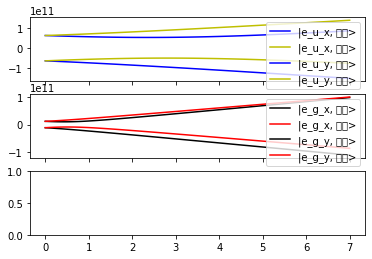

In [17]:
labels = [
    '|e_g_x, 🠕>',
    '|e_g_x, 🠗>',
    '|e_g_y, 🠕>',
    '|e_g_y, 🠗>',
    '|e_u_x, 🠕>',
    '|e_u_x, 🠗>',
    '|e_u_y, 🠕>',
    '|e_u_y, 🠗>']
colors = [
    'k',
    'r',
    'k',
    'r',
    'b',
    'y',
    'b',
    'y'
]

fig, axs = plt.subplots(3,1,True)
for i, energy in enumerate(energies):
    if i<4:
        axs[1].plot(Bs, energy, linestyle='-', label=labels[i], color=colors[i])
    else:
        axs[0].plot(Bs, energy-1.68*e/h, linestyle='-', label=labels[i], color=colors[i])
    
axs[0].legend()
axs[1].legend()
plt.show()

array([2.45304643e+10, 1.83617876e+11, 1.90594558e+09, 4.07409822e+14,
       7.45385880e+10, 1.60419809e+11, 5.19140693e+10])